In [4]:
# !pip install kaggle
!pip install statsmodels 
!pip install pmdarima

In [5]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c web-traffic-time-series-forecasting

 89% 90.0M/101M [00:00<00:00, 125MB/s]
100% 101M/101M [00:00<00:00, 148MB/s] 
 97% 146M/150M [00:01<00:00, 117MB/s]
100% 150M/150M [00:01<00:00, 117MB/s]
 94% 64.0M/68.2M [00:00<00:00, 97.1MB/s]
100% 68.2M/68.2M [00:00<00:00, 116MB/s] 
 83% 55.0M/66.0M [00:00<00:00, 74.2MB/s]
100% 66.0M/66.0M [00:00<00:00, 96.5MB/s]
 89% 91.0M/102M [00:00<00:00, 89.7MB/s]
100% 102M/102M [00:00<00:00, 111MB/s]  
 93% 89.0M/96.0M [00:00<00:00, 119MB/s]
100% 96.0M/96.0M [00:00<00:00, 150MB/s]


In [ ]:
! unzip web-traffic-time-series-forecasting.zip

unzip:  cannot find or open web-traffic-time-series-forecasting.zip, web-traffic-time-series-forecasting.zip.zip or web-traffic-time-series-forecasting.zip.ZIP.


In [9]:
! unzip train_1.csv.zip
! unzip train_2.csv.zip

Archive:  train_1.csv.zip
  inflating: train_1.csv             
Archive:  train_2.csv.zip
  inflating: train_2.csv             


In [11]:
# Importing libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Importing train_1
train_1 = pd.read_csv('train_1.csv').fillna(0)
print(train_1.shape)
train_1.head()

(145063, 551)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [13]:
# Importing train_2
train_2 = pd.read_csv('train_2.csv').fillna(0)
print(train_2.shape)
train_2.head()

(145063, 804)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [14]:
train2_flattened = pd.melt(train_2[list(train_2.columns[-100:])+['Page']], id_vars='Page', var_name='Date', value_name='Visits')
train2_flattened['Date'] = train2_flattened['Date'].astype('datetime64[ns]')
train2_flattened['Weekend'] = ((train2_flattened.Date.dt.dayofweek) // 5 == 1).astype(float)
train2_final = train2_flattened[['Date','Visits']].set_index('Date')
print(train2_final.shape)
train2_final.head()

(14506300, 1)


,Visits
Date,
2017-06-03,30.0
2017-06-03,31.0
2017-06-03,4.0
2017-06-03,14.0
2017-06-03,12.0


In [15]:
train_flattened = pd.melt(train_1[list(train_1.columns[-100:])+['Page']], id_vars='Page', var_name='Date', value_name='Visits')
train_flattened['Date'] = train_flattened['Date'].astype('datetime64[ns]')
train_flattened['Weekend'] = ((train_flattened.Date.dt.dayofweek) // 5 == 1).astype(float)
print(train_flattened.shape)
train_flattened.head()

(14506300, 4)


,Page,Date,Visits,Weekend
0,2NE1_zh.wikipedia.org_all-access_spider,2016-09-23,10.0,0.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-09-23,26.0,0.0
2,3C_zh.wikipedia.org_all-access_spider,2016-09-23,3.0,0.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-09-23,14.0,0.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-09-23,3.0,0.0


In [16]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['Median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['Mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [17]:
train_flattened.reset_index(drop=False,inplace=True)

In [18]:
train_flattened['Weekday'] = train_flattened['Date'].apply(lambda x: x.weekday())

In [19]:
# Feature engineering with the date
train_flattened['Year'] = train_flattened.Date.dt.year 
train_flattened['Month'] = train_flattened.Date.dt.month 
train_flattened['Day'] = train_flattened.Date.dt.day
print(train_flattened.shape)
train_flattened.head()

(14506300, 10)


,Page,Date,Visits,Weekend,Mean,Median,Weekday,Year,Month,Day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-09-23,3.0,0.0,3.46,3.0,4,2016,9,23
1,!vote_en.wikipedia.org_all-access_all-agents,2016-09-24,1.0,1.0,3.46,3.0,5,2016,9,24
2,!vote_en.wikipedia.org_all-access_all-agents,2016-09-25,2.0,1.0,3.46,3.0,6,2016,9,25
3,!vote_en.wikipedia.org_all-access_all-agents,2016-09-26,7.0,0.0,3.46,3.0,0,2016,9,26
4,!vote_en.wikipedia.org_all-access_all-agents,2016-09-27,5.0,0.0,3.46,3.0,1,2016,9,27


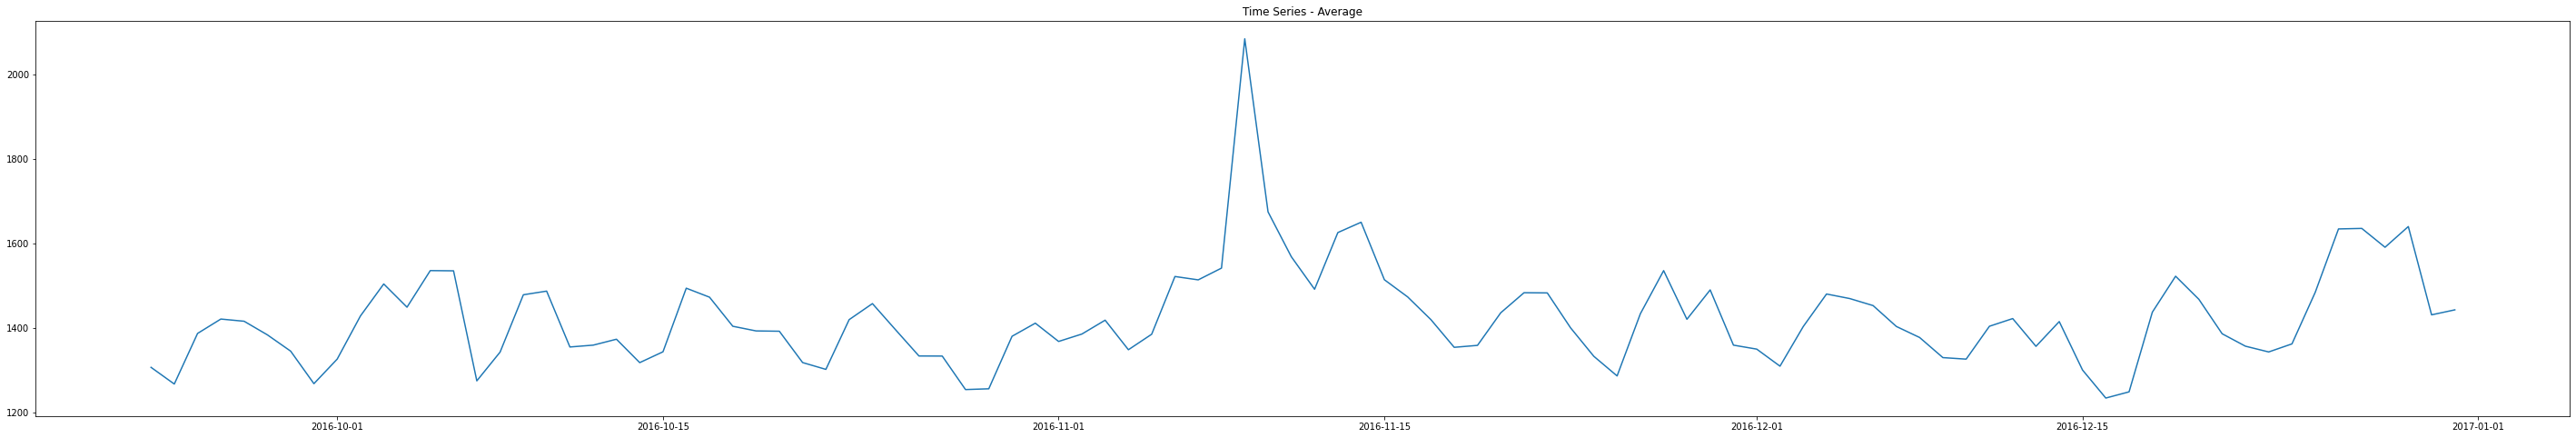

In [20]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','Date','Visits']].groupby(['Date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

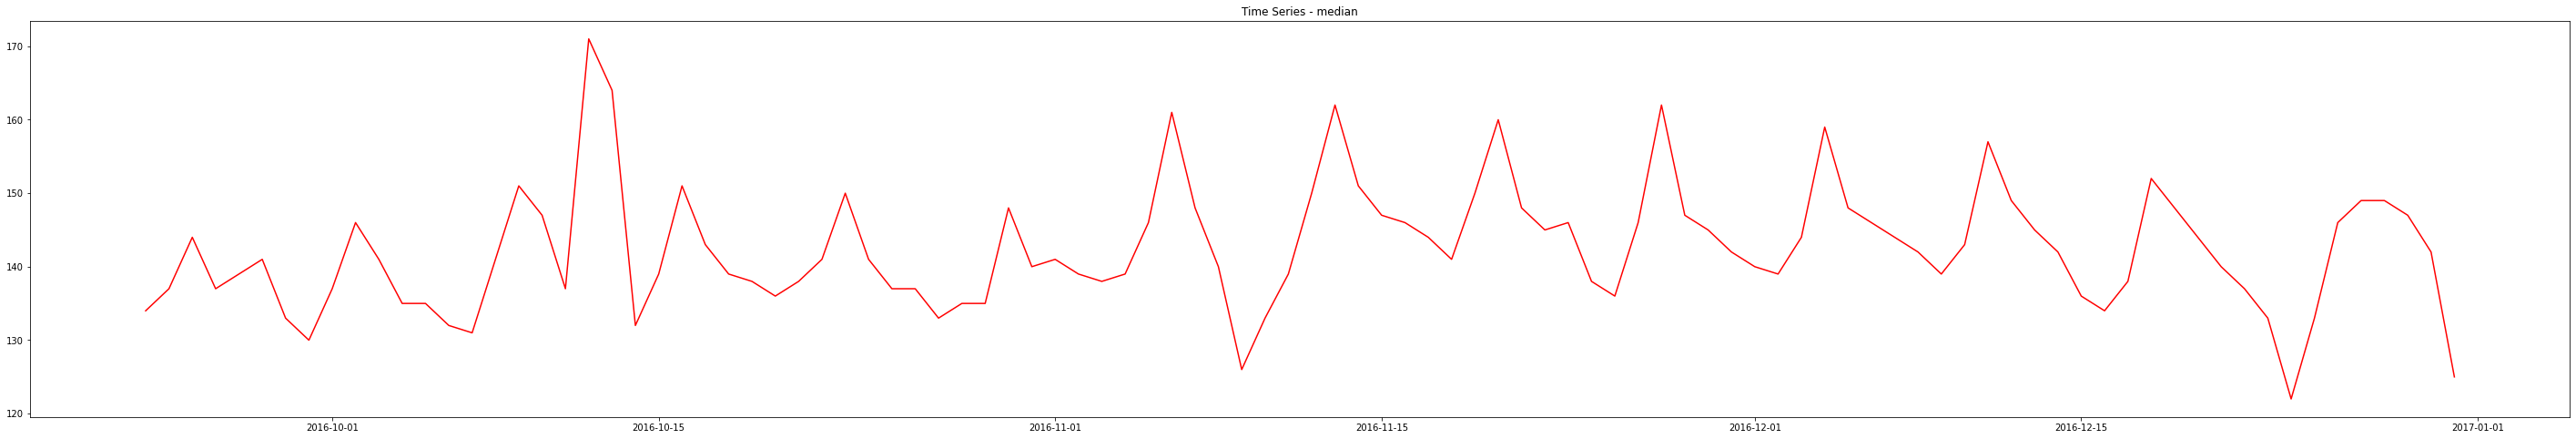

In [21]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','Date','Visits']].groupby(['Date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

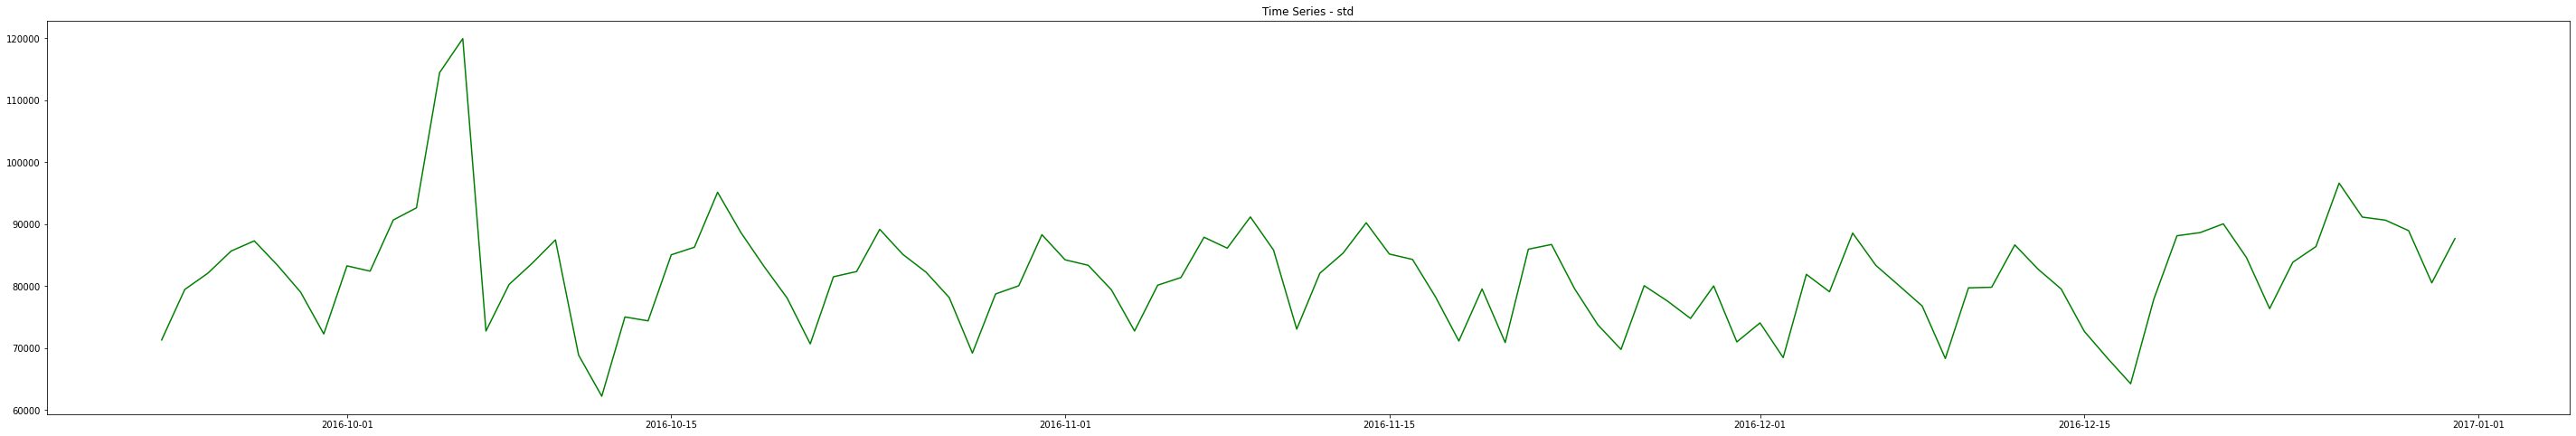

In [22]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','Date','Visits']].groupby(['Date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [23]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['Weekday'] = times_series_means['Date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['Date'].apply(lambda x: str(x))
times_series_means[['Year','Month','Day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['Year','Month','Day'])
date_staging = pd.DataFrame(times_series_means['Day'].str.split(' ',2).tolist(), columns = ['Day','other'])
times_series_means['Day'] = date_staging['Day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
print(times_series_means.shape)
times_series_means.head()

(100, 6)


,Date,Visits,Weekday,Year,Month,Day
0,2016-09-23,1307.048910,4,2016,09,23
1,2016-09-24,1267.586759,5,2016,09,24
2,2016-09-25,1387.193523,6,2016,09,25
3,2016-09-26,1421.203967,0,2016,09,26
4,2016-09-27,1416.020715,1,2016,09,27


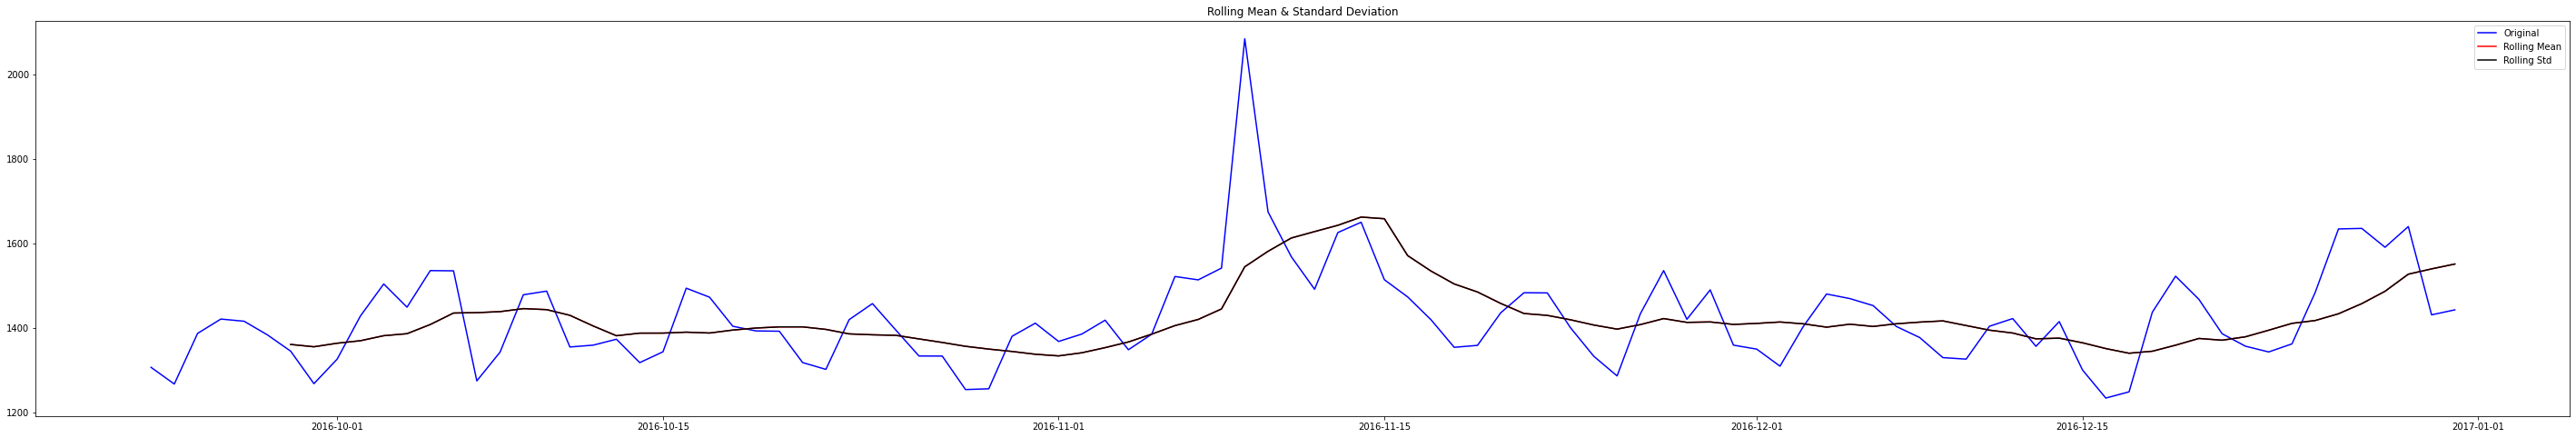

Results of Dickey-Fuller Test:
Test Statistic                 -4.999958
p-value                         0.000022
#Lags Used                      0.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [24]:
# Show Rolling mean, Rolling Std and Test for the stationarity
times_series_means.reset_index(drop=True,inplace=True)
df_date_index = times_series_means[['Date','Visits']].set_index('Date')

def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).mean()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['Visits'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)

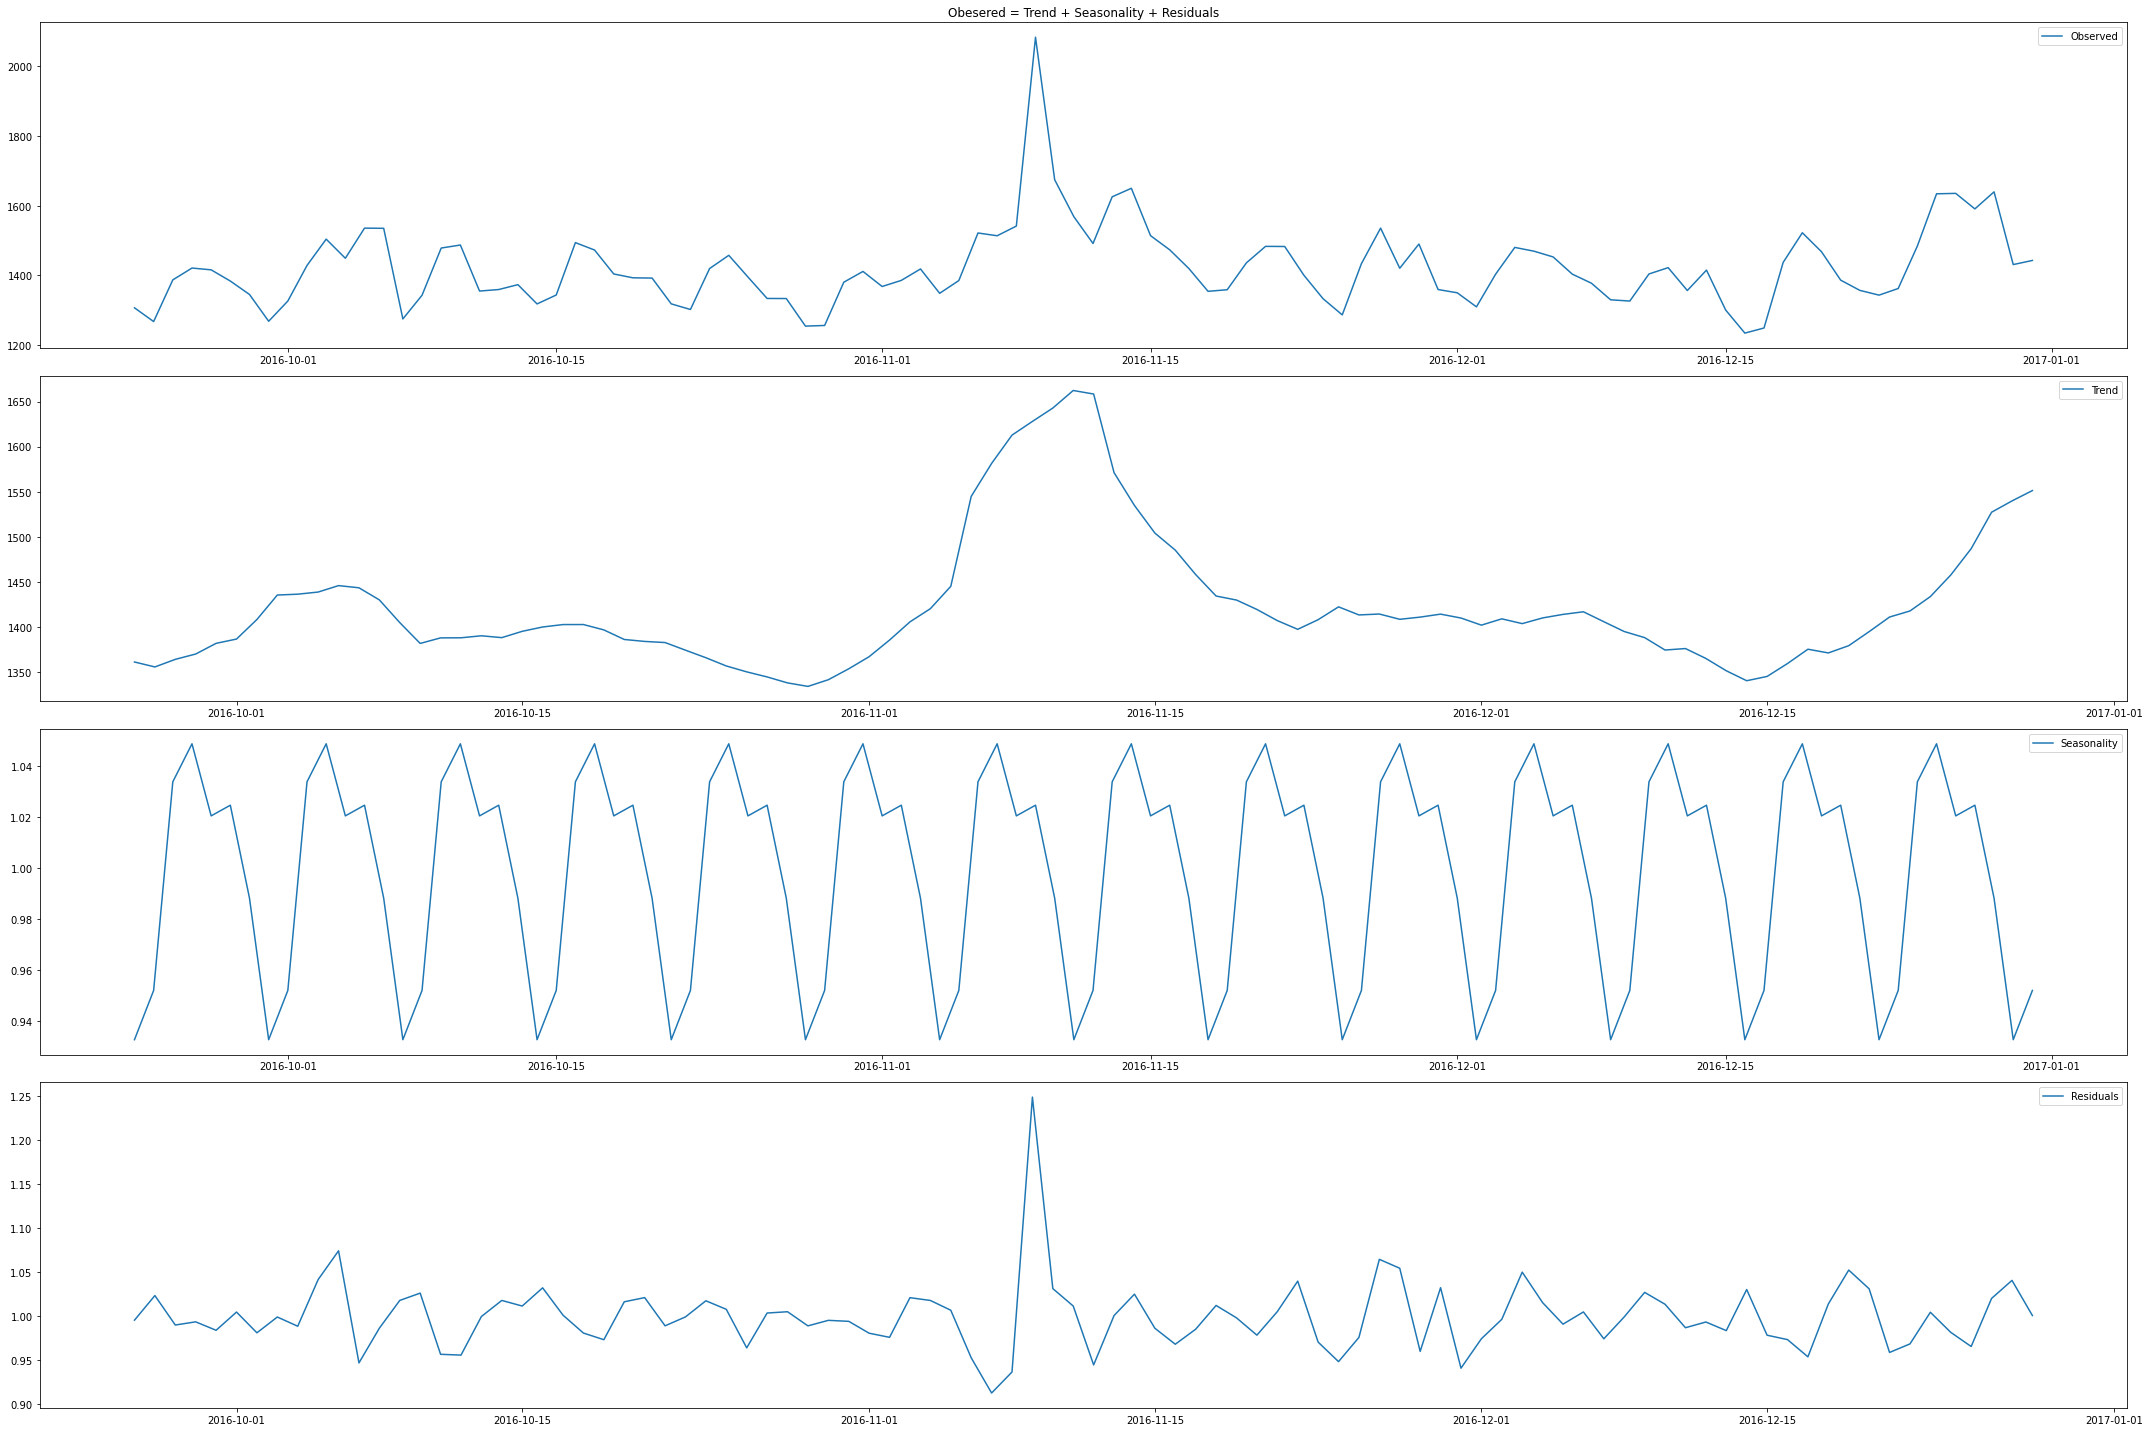

In [25]:
from pylab import rcParams

# Naive decomposition of our Time Series as explained above
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 30, 20

plt.subplot(411)
plt.title('Obesered = Trend + Seasonality + Residuals')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

(100, 1)
                 Visits
Date                   
2016-09-23  1307.048910
2016-09-24  1267.586759
2016-09-25  1387.193523
2016-09-26  1421.203967
2016-09-27  1416.020715


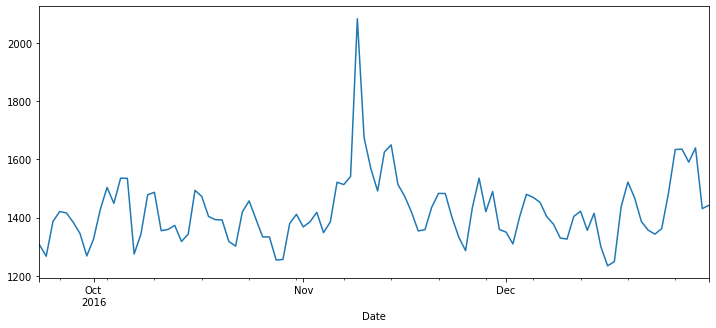

In [26]:
# Considering time series for only one Wiki page and Plotting data
ts = df_date_index
print(ts.shape)
print(ts.head())
ts['Visits'].plot(figsize=(12, 5))

In [27]:
# Augmented Dickey Fuller Test
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

adf_test(ts['Visits'])

1. ADF :  -4.999957776996715
2. P-Value :  2.2197425343545827e-05
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 99
5. Critical Values :
	 1% :  -3.498198082189098
	 5% :  -2.891208211860468
	 10% :  -2.5825959973472097


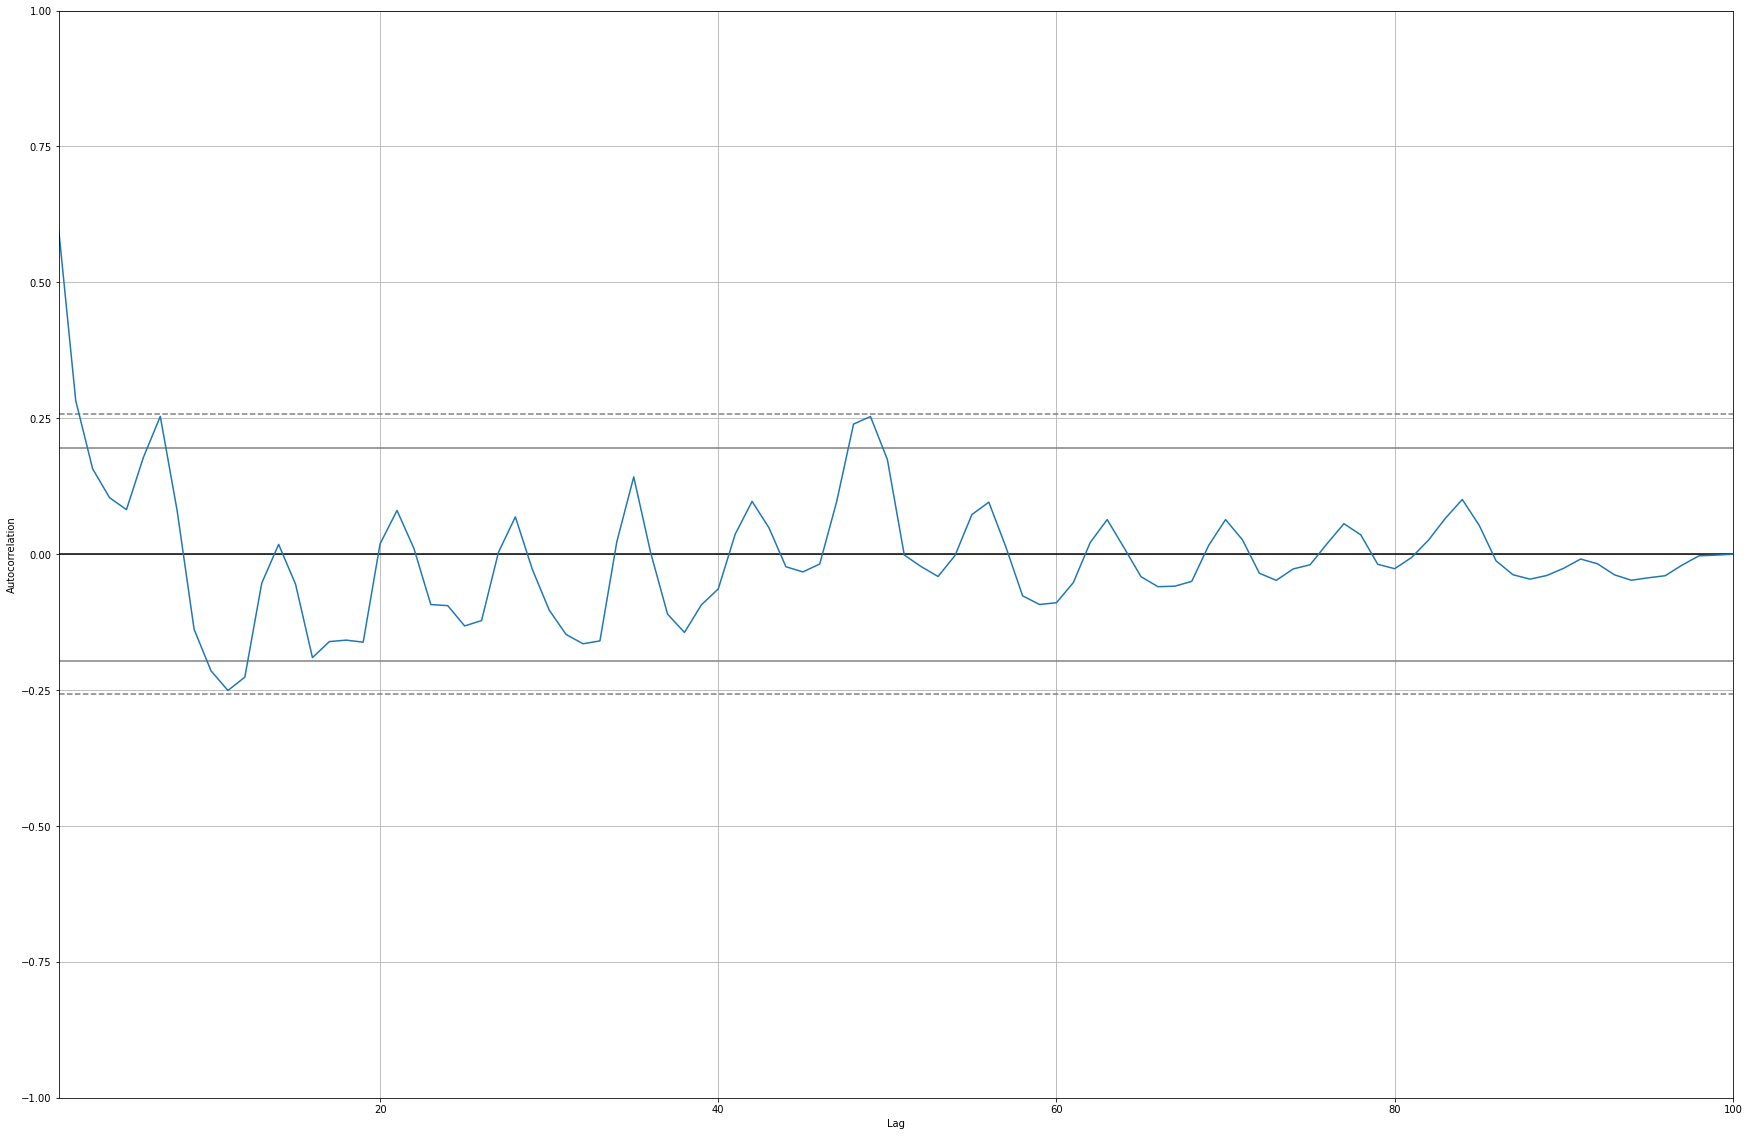

In [28]:
# Auto Correlation Plot
pd.plotting.autocorrelation_plot(ts['Visits'])

In [29]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(ts['Visits'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1201.883, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1239.028, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1197.212, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1203.546, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1738.580, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1198.125, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1198.268, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1200.180, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.881 seconds


In [30]:
#Change order value based on above results
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts['Visits'], order=(1,0,0))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Visits   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -595.608
Date:                Thu, 09 Dec 2021   AIC                           1197.216
Time:                        21:26:36   BIC                           1205.031
Sample:                    09-23-2016   HQIC                          1200.379
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1423.1589     29.540     48.178      0.000    1365.262    1481.056
ar.L1          0.5952      0.073      8.106      0.000       0.451       0.739
sigma2      8689.6501    566.999     15.326      0.0

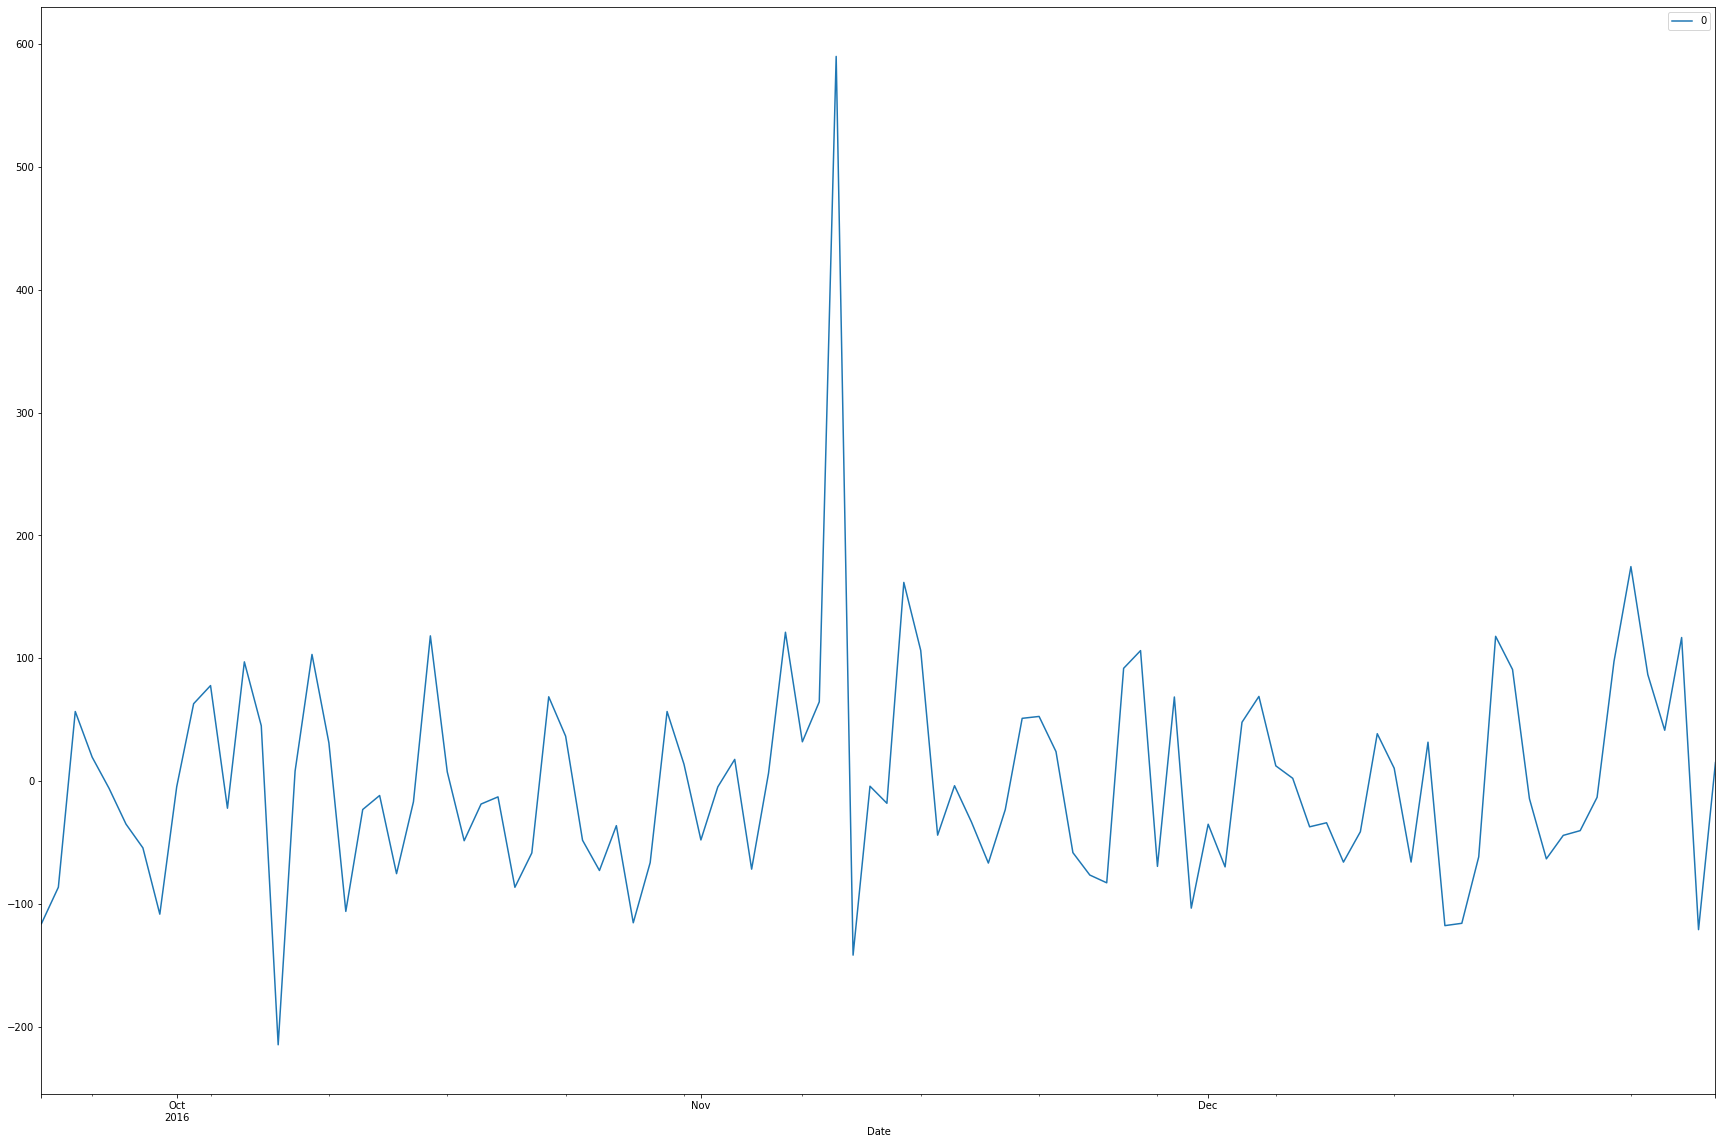

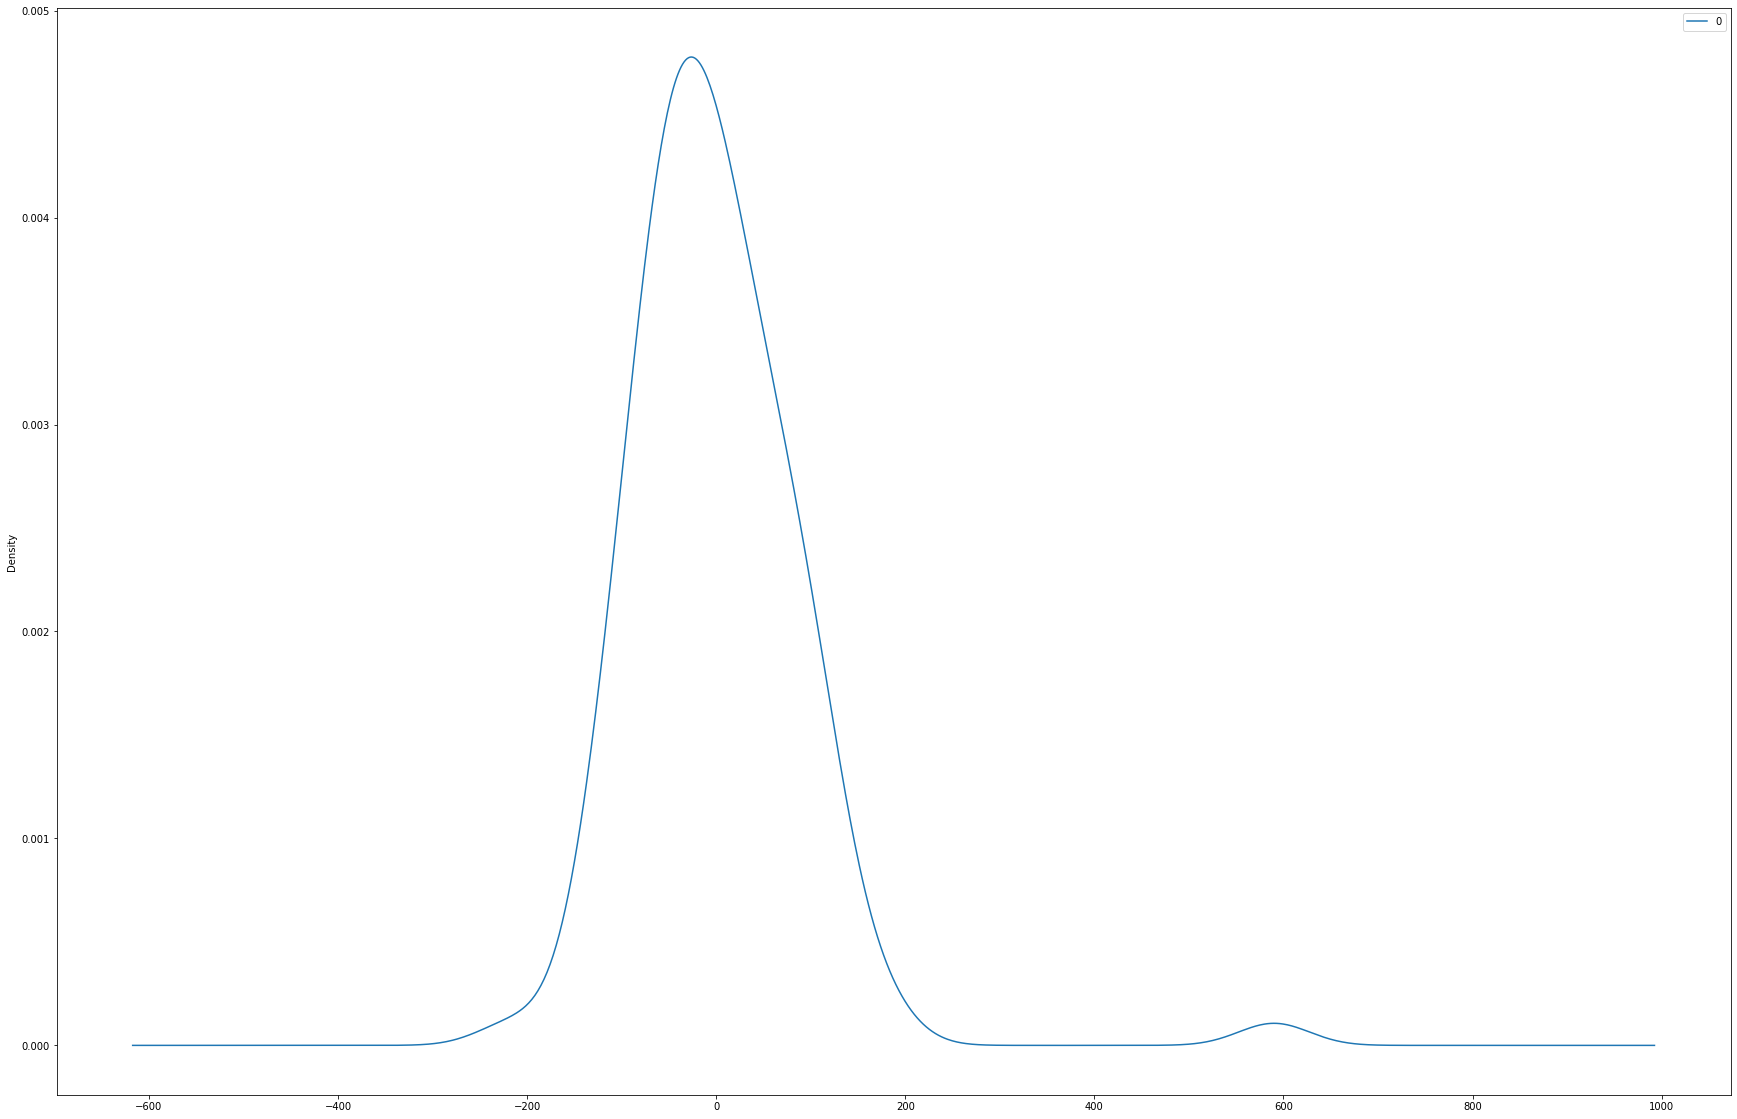

                0
count  100.000000
mean     0.118104
std     93.945798
min   -214.747514
25%    -59.346405
50%    -12.322658
75%     48.669007
max    590.057684


In [31]:
# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [36]:
train = ts
test = train2_final[-50:]
print(train.shape, test.shape)
test.head()

(100, 1) (50, 1)


,Visits
Date,
2017-09-10,2.0
2017-09-10,11.0
2017-09-10,4.0
2017-09-10,0.0
2017-09-10,5.0


100 149


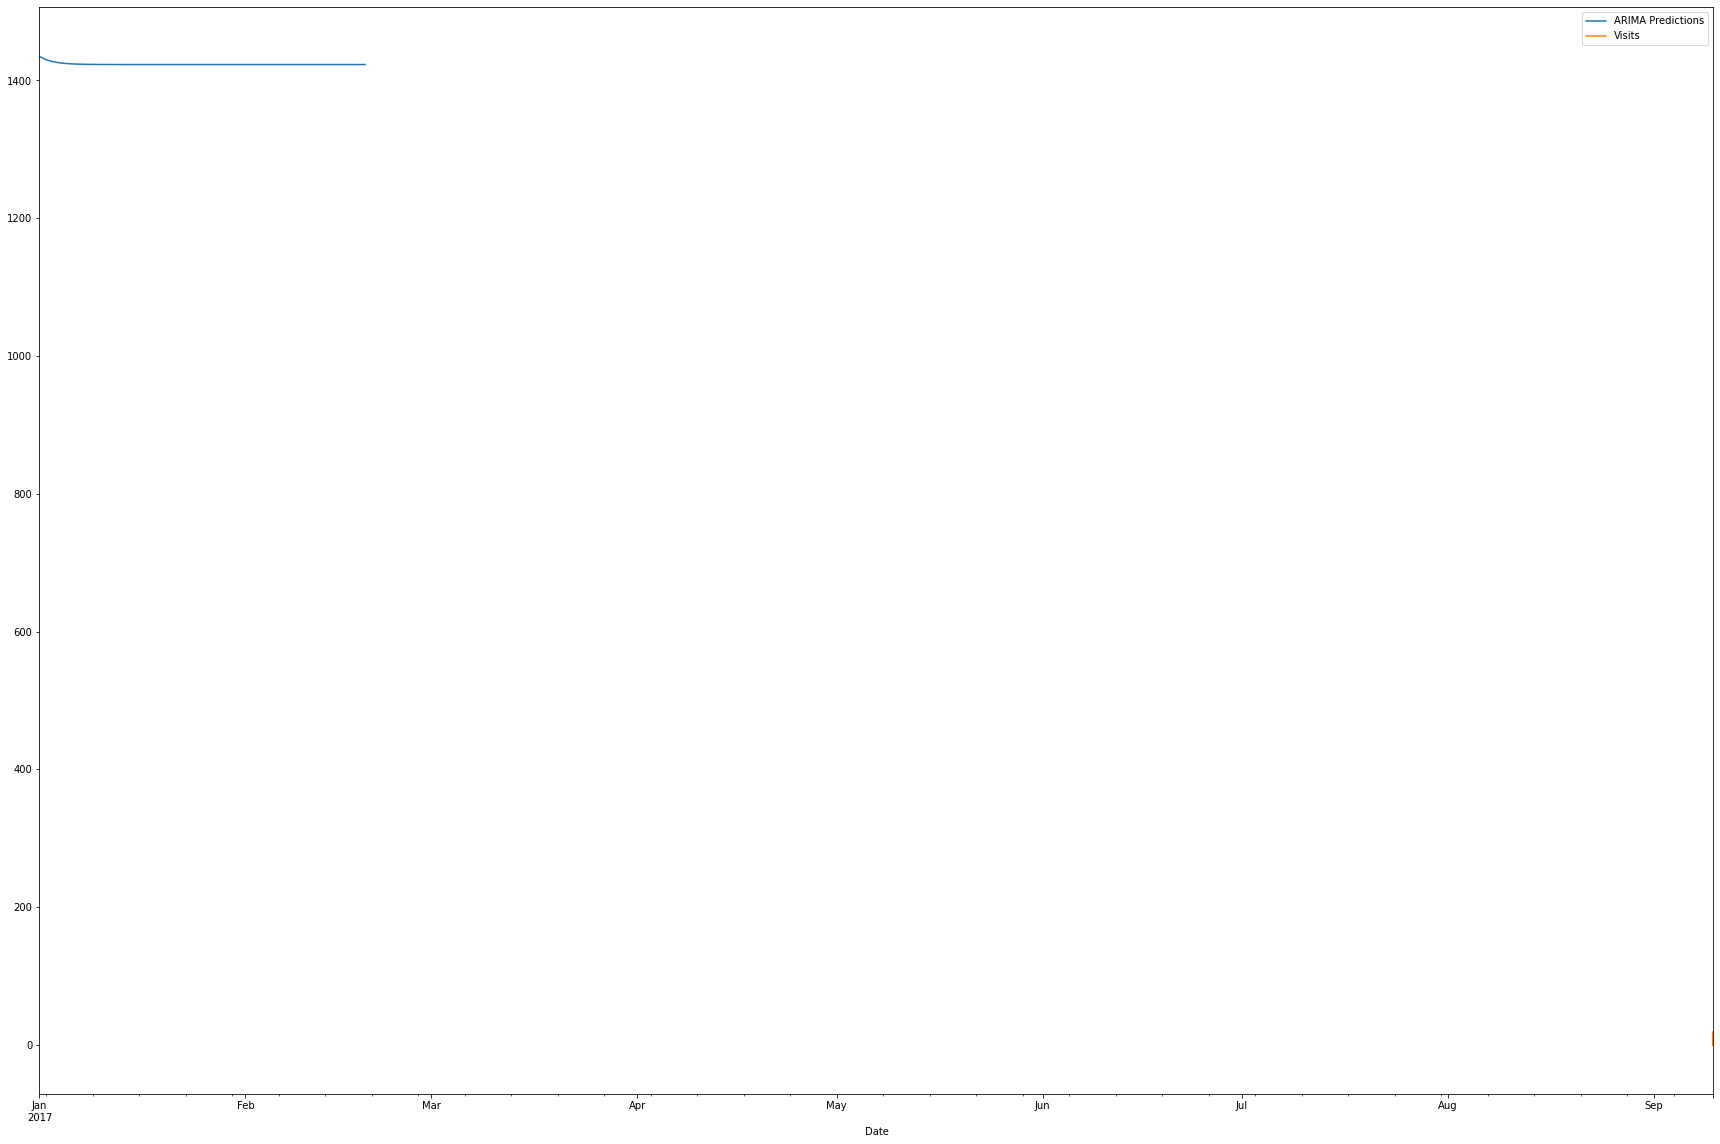

In [37]:
start = len(train)
end = len(train) + len(test) - 1
print(start, end)
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Visits'].plot(legend=True)

In [35]:
# One way for RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

test['Visits'].mean()
rmse = sqrt(mean_squared_error(pred, test['Visits']))
print(rmse)

1414.105846645323


In [ ]:
# Another way of predicting

from sklearn.metrics import mean_squared_error
from math import sqrt

train = train2_final[0:550]['Visits'].values
test = train2_final[550:803]['Visits'].values
# X = ts['Visits'].values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model1 = ARIMA(history, order=(1,1,2))
	model_fit = model1.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
 
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=30.319990, expected=27.000000
predicted=30.142005, expected=58.000000
predicted=33.623758, expected=47.000000
predicted=34.592036, expected=10.000000
predicted=30.933736, expected=29.000000
predicted=30.815747, expected=79.000000
predicted=36.487738, expected=21.000000
predicted=33.477743, expected=39.000000
predicted=33.652741, expected=16.000000
predicted=31.160483, expected=37.000000
predicted=31.957491, expected=19.000000
predicted=30.416491, expected=8.000000
predicted=28.149797, expected=13.000000
predicted=27.220530, expected=37.000000
predicted=29.369004, expected=20.000000
predicted=28.747017, expected=12.000000
predicted=27.397321, expected=17.000000
predicted=27.072177, expected=11.000000
predicted=26.107718, expected=11.000000
predicted=25.436359, expected=12.000000
predicted=25.046511, expected=35.000000
predicted=27.456413, expected=25.000000
predicted=27.811822, expected=16.000000
predicted=26.967380, expected=20.000000
predicted=26.865539, expected=69.000000
p